## Решающее дерево для задачи классификации

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(67)
points = np.random.uniform(size=(20, 2), low=-1, high=1)
positive = points[np.logical_xor(points[:, 0] >= 0, points[:, 1] >= 0)]
negative = points[np.logical_xor(points[:, 0] >= 0, points[:, 1] < 0)]
train_data = np.vstack([positive, negative])
train_labels = np.hstack([np.ones(positive.shape[0]), np.zeros(negative.shape[0])])

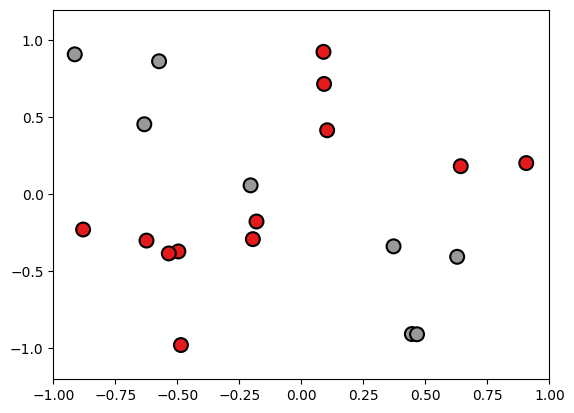

In [3]:
plt.scatter(train_data[:, 0], train_data[:, 1], 
            c=train_labels, s=100, cmap='Set1', edgecolors='black', linewidth=1.5)
plt.xlim(-1, 1)
plt.ylim(-1.2, 1.2)
plt.show()

In [4]:
class DecisionTreeClassificator:
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.splits = {}
    
    @staticmethod
    def information_gain(train_data, train_labels, feature_id, condition, criterion='entropy'):
        if criterion == 'entropy':
            y_L = train_labels[train_data[:, feature_id] < condition]
            y_R = train_labels[train_data[:, feature_id] >= condition]
            nL = len(y_L[y_L == 1])
            NL = len(y_L)
            NR = len(y_R)
            nR = len(y_R[y_R == 1])
            n0 = len(y_L)
            n = len(train_labels)
            if NL == 0 and NR == 0:
                return 1
            elif NL == 0:
                #S_0 = - n0 / n * np.log2(n0 / n) - (n - n0) / n * np.log2((n - n0) / n)
                S_L = 1
                if nR / NR == 0 or nR / NR == 1:
                    S_R = 0
                else:
                    S_R = - nR / NR * np.log2(nR / NR) - (NR - nR) / NR * np.log2((NR - nR) / NR)
            elif NR == 0:
                #S_0 = - n0 / n * np.log2(n0 / n) - (n - n0) / n * np.log2((n - n0) / n)
                S_R = 1
                if nL / NL == 0 or nL / NL == 1:
                    S_L = 0
                else:
                    S_L = - nL / NL * np.log2(nL / NL) - (NL - nL) / NL * np.log2((NL - nL) / NL)
            elif nR / NR == 0 or nR / NR == 1:
                S_R = 0
                S_L = - nL / NL * np.log2(nL / NL) - (NL - nL) / NL * np.log2((NL - nL) / NL)
            elif nL / NL == 0 or nL / NL == 1:
                S_L = 0
                S_R = - nR / NR * np.log2(nR / NR) - (NR - nR) / NR * np.log2((NR - nR) / NR)
            else:
                #S_0 = - n0 / n * np.log2(n0 / n) - (n - n0) / n * np.log2((n - n0) / n)
                S_L = - nL / NL * np.log2(nL / NL) - (NL - nL) / NL * np.log2((NL - nL) / NL)
                S_R = - nR / NR * np.log2(nR / NR) - (NR - nR) / NR * np.log2((NR - nR) / NR)
            return - (- n0 / n * S_L - (n - n0) / n * S_R)
        else:
            y_L = train_labels[train_data[:, feature_id] < condition]
            y_R = train_labels[train_data[:, feature_id] >= condition]
            nL = len(y_L[y_L == 1])
            NL = len(y_L)
            NR = len(y_R)
            nR = len(y_R[y_R == 1])
            n0 = len(y_L)
            n = len(train_labels)
            if NL == 0 and NR == 0:
                return 0
            elif NL == 0:
                G_L = 1
                G_R = 1 - (nR / NR)**2 - ((NR - nR) / NR)**2
                return -(- n0 / n * G_L - (n - n0) / n * G_R) * 2
            elif NR == 0:
                G_L = 1 - (nL / NL)**2 - ((NL - nL) / NL)**2
                G_R = 1
                return -(- n0 / n * G_L - (n - n0) / n * G_R) * 2
            else:
                G_L = 1 - (nL / NL)**2 - ((NL - nL) / NL)**2
                G_R = 1 - (nR / NR)**2 - ((NR - nR) / NR)**2
                return -(- n0 / n * G_L - (n - n0) / n * G_R) * 2
        
    @staticmethod
    def get_conditions(train_data, train_labels):
        n = len(train_data[0])
        res = {}
        for i in range(n):
            x = np.argsort(train_data[:,i])
            r = []
            for j in range(1, len(x)):
                if train_labels[x[j - 1]] != train_labels[x[j]]:
                    r.append(np.mean([train_data[x[j - 1]][i], train_data[x[j]][i]]))
            res[i] = r
        return res
    
    def get_best_predicate(self, X, y):
        dict_conditions = self.get_conditions(X, y)

        min_information_gain_value = float('inf')
        min_condition = float('inf')
        min_feature = float('inf')

        for feature, conditions in dict_conditions.items():
            for condition in conditions:
                value = self.information_gain(X, y, feature, condition, criterion="gini")
                if min_information_gain_value > value:
                    min_information_gain_value = value
                    min_condition = condition
                    min_feature = feature
                # print(f"{feature} {condition} {value}")
        return (min_feature, min_condition)
    
    def desicion_tree_step(self, X, y, max_depth, level=0):
        if level == max_depth:
            return {"target": y.mean()}

        best_predicate = self.get_best_predicate(X, y)

        try:
            left_half = X[:, best_predicate[0]] < best_predicate[1]
            right_half = X[:, best_predicate[0]] >= best_predicate[1]

            X_left, y_left = X[left_half], y[left_half]
            X_right, y_right = X[right_half], y[right_half]

            return {
                "level": level,
                "predicate": best_predicate,
                "target": y.mean(),
                "left": self.desicion_tree_step(X_left, y_left, max_depth, level + 1),
                "right": self.desicion_tree_step(X_right, y_right, max_depth, level + 1),
            }
        except:
            return {"target": y.mean()}
        
    def fit(self, X, y):
        self.splits = self.desicion_tree_step(X, y, self.max_depth)
    
    def predict_proba_step(self, element, split):
        if "predicate" not in split.keys():
            return split["target"]

        current_predicate_axis, current_predicate_condition = split["predicate"]
        if element[current_predicate_axis] < current_predicate_condition:
            return self.predict_proba_step(element, split["left"])
        else:
            return self.predict_proba_step(element, split["right"])
    
    def predict_proba(self, X):
        if self.splits == {}:
            print("Error: Need to fit the model")
            return
        return np.array([self.predict_proba_step(element, self.splits) for element in X])
    
    def predict(self, X):
        if self.splits == {}:
            print("Error: Need to fit the model")
            return
        return (self.predict_proba(X) > 0.5).astype(int)

In [5]:
dt = DecisionTreeClassificator()

In [6]:
dt.fit(train_data, train_labels)

In [7]:
dt.predict_proba(train_data)

array([0.33333333, 1.        , 1.        , 1.        , 0.33333333,
       1.        , 1.        , 1.        , 0.        , 0.        ,
       0.        , 0.33333333, 0.        , 0.        , 0.33333333,
       0.33333333, 0.        , 0.        , 0.33333333, 0.        ])

In [8]:
dt.predict(train_data)

array([0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Решающее дерево для задачи регрессии

In [9]:
X = np.linspace(-2, 2, 7)
y = X ** 3

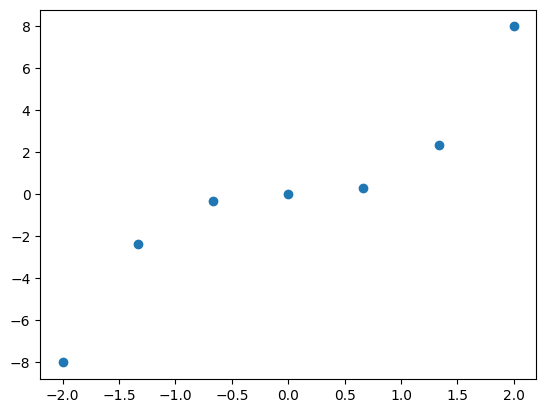

In [10]:
plt.scatter(X, y)
plt.show()

In [11]:
class DecisionTreeRegressor:
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.splits = {}
    
    @staticmethod
    def variance_criterion(y):
        return 1/len(y) * sum((yi - 1/len(y) * y.sum()) ** 2 for yi in y)
    
    def information_gain(self, X, y, condition):
        y_U0 = y[X < condition]
        y_U1 = y[X >= condition]
        NU = len(y)
        NU0 = len(y_U0)
        NU1 = len(y_U1)
        if NU0 == 0 and NU1 == 0:
            return 0
        elif NU0 == 0:
            DU0 = 1
            DU1 = self.variance_criterion(y_U1)
        elif NU1 == 0:
            DU0 = self.variance_criterion(y_U0)
            DU1 = 1
        else:
            DU0 = self.variance_criterion(y_U0)
            DU1 = self.variance_criterion(y_U1)
        return -(- NU0 / NU * DU0 - NU1 / NU * DU1)
    
    @staticmethod
    def get_conditions(X):
        return np.linspace(X.min(), X.max(), 20)
    
    def get_best_predicate(self, X, y):
        conditions = self.get_conditions(X)

        min_information_gain_value = float('inf')
        min_condition = float('inf')

        for condition in conditions:
            value = self.information_gain(X, y, condition)
            # print(condition, value)
            if min_information_gain_value > value:
                min_information_gain_value = value
                min_condition = condition

        return min_condition
    
    def desicion_tree_step(self, X, y, max_depth, level=0):
        if level == max_depth:
            return {"target": y.mean()}

        best_predicate = self.get_best_predicate(X, y)
        
        if best_predicate == X.min():
            return {"target": y.mean()}

        try:
            left_half = X < best_predicate
            right_half = X >= best_predicate

            X_left, y_left = X[left_half], y[left_half]
            X_right, y_right = X[right_half], y[right_half]
            
            return {
                "level": level,
                "predicate": best_predicate,
                "target": y.mean(),
                "left": self.desicion_tree_step(X_left, y_left, max_depth, level + 1),
                "right": self.desicion_tree_step(X_right, y_right, max_depth, level + 1),
            }
        except:
            return {"target": y.mean()}
    
    def fit(self, X, y):
        self.splits = self.desicion_tree_step(X, y, self.max_depth)
        
    def predict_step(self, element, split):
        if "predicate" not in split.keys():
            return split["target"]

        current_predicate_condition = split["predicate"]
        if element < current_predicate_condition:
            return self.predict_step(element, split["left"])
        else:
            return self.predict_step(element, split["right"])
    
    def predict(self, X):
        if self.splits == {}:
            print("Error: Need to fit the model")
            return
        return np.array([self.predict_step(element, self.splits) for element in X])

In [12]:
dt = DecisionTreeRegressor()

In [13]:
dt.fit(X, y)

In [14]:
y_predict = dt.predict(X)
y_predict

array([-8.00000000e+00, -2.37037037e+00, -9.25185854e-17, -9.25185854e-17,
       -9.25185854e-17,  2.37037037e+00,  8.00000000e+00])

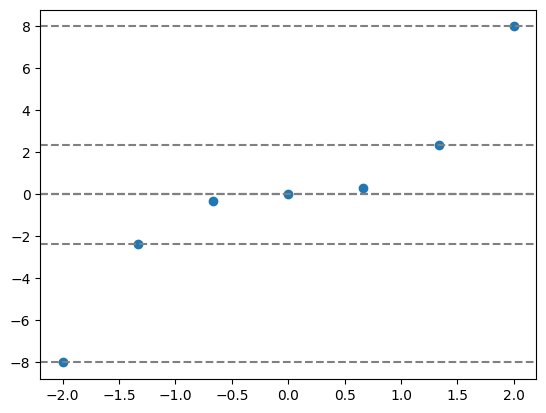

In [28]:
plt.scatter(X, y)
for y_pred in y_predict:
    plt.axhline(y=y_pred, color='gray', linestyle='--')
plt.show()